In [ ]:
import glob
import math
import ntpath
import os
import warnings

import edfreader
import matplotlib.pyplot as plt
import mne
import models
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings('ignore')

from matplotlib.backends.backend_pdf import PdfPages
from mne.datasets.sleep_physionet._utils import _fetch_one, _data_path, AGE_SLEEP_RECORDS
from datetime import datetime
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pyeeg # pip install git+https://github.com/forrestbao/pyeeg.git
from keras.src.utils import to_categorical
from keras.src.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, classification_report, log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from hurst import compute_Hc

warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

warnings.filterwarnings('ignore')

In [ ]:
VBS = True  # constant boolean to enable/disbale verbose
EPOCH_SEC_SIZE = 30  # Epoch duration selection
seed = 42  # seed value for the random seeds
batch_size = 64
number_of_subj = 50

# values to label the stages
UNKNOWN = -1
W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4

# making string dictionary for the label values
label_dict = {
    "UNKNOWN"  : UNKNOWN,
    "W"        : W,
    "N1"       : N1,
    "N2"       : N2,
    "N3"       : N3,
    "REM"      : REM
}

# converting from label values to strings
class_dict = {
    -1: "UNKNOWN",
    0 : "W",
    1 : "N1",
    2 : "N2",
    3 : "N3",
    4 : "REM"
}

# annotation dictionary to convert from string to label values
annot2label = {
    "Sleep stage ?": -1,
    "Movement time": -1,
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4
}
project_path = os.path.abspath(os.getcwd())  # finding the current project path in windows

In [ ]:
# localized fetch_data function by using mne library
# https://github.com/mne-tools/mne-python/blob/maint/0.20/mne/datasets/sleep_physionet/age.py#L18-L111
data_path = _data_path
BASE_URL = 'https://physionet.org/physiobank/database/sleep-edfx/sleep-cassette/'
def fetch_data(subjects, recording=None, path=None, force_update=False,
               base_url=BASE_URL,
               verbose=None):  # noqa: D301
    if recording is None:
        recording = [1, 2]
    records = np.loadtxt(AGE_SLEEP_RECORDS,
                         skiprows=1,
                         delimiter=',',
                         usecols=(0, 1, 2, 6, 7),
                         dtype={'names': ('subject', 'record', 'type', 'sha',
                                          'fname'),
                                'formats': ('<i2', 'i1', '<S9', 'S40', '<S22')}
                         )
    psg_records = records[np.where(records['type'] == b'PSG')]
    hyp_records = records[np.where(records['type'] == b'Hypnogram')]

    path = data_path(path=path)
    params = [path, force_update, base_url]
    fnames = []
    for subject in subjects:
        for idx in np.where(psg_records['subject'] == subject)[0]:
            if psg_records['record'][idx] in recording:
                psg_fname = _fetch_one(psg_records['fname'][idx].decode(),
                                       psg_records['sha'][idx].decode(),
                                       *params)
                hyp_fname = _fetch_one(hyp_records['fname'][idx].decode(),
                                       hyp_records['sha'][idx].decode(),
                                       *params)
                fnames.append([psg_fname, hyp_fname])

    return fnames

In [ ]:
subjects_list = []  # list to keep the address of the subject data
except_sub = [13, 36, 52]  # omitting the subjects with incomplete data

# for i in range(83):
#     if i in except_sub:
#         continue
#     subjects_list.append(i)
subjects_list = [0,1]

# fetching data of each subject and
subject_files = fetch_data(subjects=subjects_list, recording=[1, 2], path= project_path)
mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

In [ ]:
ch_labels = 'EEG Fpz-Cz'  # channels to be selected
data_frames = []
if VBS:
    print("Importing data into dataframes:")
output_path = os.path.join(project_path, "NPZ_files")  # path to save the npz files
# loop to preprocess input data and save the results in npz files to be used in our models later
for edf_item in tqdm(subject_files):
    # v2_upt item[0] > edf_item[0][0]
    filename = ntpath.basename(edf_item[0][0]).replace("-PSG.edf", ".npz")  # reading the PSG files
    if not os.path.exists(os.path.join(output_path, filename)):
        raw_train = mne.io.read_raw_edf(edf_item[0][0], verbose=VBS)
        sampling_rate = raw_train.info['sfreq']
        raw_ch_df = raw_train.to_data_frame()[ch_labels]
        raw_ch_df = raw_ch_df.to_frame()
        raw_ch_df.set_index(np.arange(len(raw_ch_df)))

        # reading the raw headers using the EDFReader function from edfreader
        f = open(edf_item[0][0], 'r', errors='ignore', encoding='utf-8')
        head_raw_read = edfreader.BaseEDFReader(f)
        head_raw_read.read_header()
        head_raw = head_raw_read.header
        f.close()
        raw_start_time = datetime.strptime(head_raw['date_time'], "%Y-%m-%d %H:%M:%S")

        # read annotations from hypnogram file
        f = open(edf_item[1][0], 'r')
        annot_raw_read = edfreader.BaseEDFReader(f)
        annot_raw_read.read_header()
        annot_raw = annot_raw_read.header
        temp, temp, total_annot = zip(*annot_raw_read.records())
        f.close()
        annot_start_time = datetime.strptime(annot_raw['date_time'], "%Y-%m-%d %H:%M:%S")
        assert raw_start_time == annot_start_time  # making sure that the PSG files and hypnogram files are in sync
        remove_idx = []    # list to keep the indicies of data that will be removed
        labels = []        # list to keep the indicies of data that have labels
        label_idx = []

        # selecting the indicies of known labels and adding the rest to remove_idx list
        for annot in total_annot[0]:
            onset_sec, duration_sec, annot_char = annot
            annot_str = "".join(annot_char)
            label = annot2label[annot_str]
            if label != UNKNOWN:
                if duration_sec % EPOCH_SEC_SIZE != 0:
                    raise Exception("Please choose anothe epoch duration!")
                duration_epoch = int(duration_sec / EPOCH_SEC_SIZE)
                label_epoch = np.ones(duration_epoch, dtype=int) * label
                labels.append(label_epoch)
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=int)
                label_idx.append(idx)
            else:
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=int)
                remove_idx.append(idx)
        labels = np.hstack(labels)
        if len(remove_idx) > 0:
            remove_idx = np.hstack(remove_idx)
            select_idx = np.setdiff1d(np.arange(len(raw_ch_df)), remove_idx)
        else:
            select_idx = np.arange(len(raw_ch_df))

        # filtering data with labels only
        label_idx = np.hstack(label_idx)
        select_idx = np.intersect1d(select_idx, label_idx)

        # removing extra indicies
        if len(label_idx) > len(select_idx):
            extra_idx = np.setdiff1d(label_idx, select_idx)
            # trimming the tail
            if np.all(extra_idx > select_idx[-1]):
                n_trims = len(select_idx) % int(EPOCH_SEC_SIZE * sampling_rate)
                n_label_trims = int(math.ceil(n_trims / (EPOCH_SEC_SIZE * sampling_rate)))
                select_idx = select_idx[:-n_trims]
                labels = labels[:-n_label_trims]

        # removing all unknown and movement labels
        raw_ch = raw_ch_df.values[select_idx]

        # check if we can split into epochs' size
        if len(raw_ch) % (EPOCH_SEC_SIZE * sampling_rate) != 0:
            raise Exception("Please choose anothe epoch duration!")
        n_epochs = len(raw_ch) / (EPOCH_SEC_SIZE * sampling_rate)

        # get epochs and their corresponding labels
        x = np.asarray(np.split(raw_ch, n_epochs)).astype(np.float32)
        y = labels.astype(np.int32)

        assert len(x) == len(y)

        # select on sleep periods
        w_edge_mins = 30
        nw_idx = np.where(y != label_dict["W"])[0]
        start_idx = nw_idx[0] - (w_edge_mins * 2)
        end_idx = nw_idx[-1] + (w_edge_mins * 2)
        if start_idx < 0: start_idx = 0
        if end_idx >= len(y): end_idx = len(y) - 1
        select_idx = np.arange(start_idx, end_idx+1)
        x = x[select_idx]
        y = y[select_idx]

        # file structure for saving
        save_dict = {
            "x": x,
            "y": y,
            "fs": sampling_rate,
            "ch_label": ch_labels,
            "header_raw": head_raw,
            "header_annotation": annot_raw,
        }
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        np.savez(os.path.join(output_path, filename), **save_dict)

In [ ]:
pdf_report = PdfPages('Sleep_Plots.pdf')
for edf_item in tqdm(subject_files[:20]):  # selecting the first 20 subjects
    raw_train = mne.io.read_raw_edf(edf_item[0][0], verbose=VBS)
    annot_train = mne.read_annotations(edf_item[1][0])  # reading the hypnogram files

    raw_train.set_annotations(annot_train, emit_warning=False)
    raw_train.set_channel_types(mapping)
    figure = plt.figure()
    figure.suptitle("Subject: " + str(edf_item[0][0][-13:-11]) + ", Night: " + str(edf_item[0][0][-11:-10]))
    # v2_upt pdf_report.savefig(figure, papertype='a0', bbox_inches='tight')
    pdf_report.savefig(figure, bbox_inches='tight')
    # v2_upt pdf_report.savefig(raw_train.plot(duration=30), papertype='a0', bbox_inches='tight')
    pdf_report.savefig(raw_train.plot(duration=30), bbox_inches='tight')

    annotation_desc_2_event_id = {'Sleep stage R': -1,
                                  'Sleep stage W': 1,
                                  'Sleep stage 1': 2,
                                  'Sleep stage 2': 3,
                                  'Sleep stage 3': 4,
                                  'Sleep stage 4': 4
    }

    events_train, _ = mne.events_from_annotations(
        raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

    # create a new event_id that unifies stages 3 and 4
    event_id = {'Sleep stage R'  : -1,
                'Sleep stage W'  : 1,
                'Sleep stage 1'  : 2,
                'Sleep stage 2'  : 3,
                'Sleep stage 3/4': 4
    }
    # plot events and saving them in PDF report
    pdf_report.savefig(mne.viz.plot_events(events_train, event_id=event_id,
                        sfreq=raw_train.info['sfreq']), bbox_inches='tight')
pdf_report.close()

In [ ]:
Fs= 100
band_list = [0.5,4,7,12,30]
PSD = []  # Power Spectral Density
PFD = []  # Petrosian Fractal Dimension
hjorths = []  # Hjorth Parameters
hursts = []  # Hurst Exponent
DFA = []  # Detrended Fluctuation Analysis
for edf_item in tqdm(subject_files[:5]):
    raw_test = mne.io.read_raw_edf(edf_item[0][0], verbose=False)
    signals_list = raw_test[0][0][0]
    first_order = np.diff(signals_list).tolist()
    PSD.append(pyeeg.bin_power(signals_list, band_list, Fs))
    PFD.append(pyeeg.pfd(signals_list, first_order))
    hjorths.append(pyeeg.hjorth(signals_list, first_order))
    hursts.append(compute_Hc(signals_list, kind='change', min_window=100))
    DFA.append(pyeeg.dfa(signals_list))

In [ ]:
if VBS:
    print("Petrosian Fractal Dimension (PFD): ", PFD)
    print("Hjorth mobility and complexity: ", hjorths)
    print("Detrended Fluctuation Analysis (DFA): ", DFA)
    print("Hurst Exponent (Hurst): ", hursts)

In [ ]:
npz_files = sorted(glob.glob(os.path.join(output_path, "*.npz")))
X = np.zeros((0, 3000, 1))
y = []
for fn in tqdm(npz_files[:number_of_subj]):
    samples = np.load(fn)
    X_data = samples['x']
    X = np.concatenate((X, X_data), axis=0)
    y.extend(samples['y'])
y = np.array(y)

In [ ]:
pd.Series(y).value_counts().plot.bar()
plt.title("Frequency of the labels in our dataset")

In [ ]:
if VBS:
    print("Shape of the input data: {}".format(X.shape))
    print("Shape of the sleep stages: {}".format(y.shape))
# splitting subjects
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
# splitting sleeping signals
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)
if VBS:
    print("Shape of the training dataset:\ntraining dataset: {}\ntest_dataset: {}\n"
          .format(X_train.shape, X_test.shape))
y_train_ = to_categorical(y_train)
y_val_ = to_categorical(y_val)
y_test_ = to_categorical(y_test)

# X_train = np.squeeze(X_train)
# X_test = np.squeeze(X_test)
# X_val = np.squeeze(X_val)

In [ ]:
pp_X_train = np.array([models.butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_train])
pp_X_val = np.array([models.butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_val])
pp_X_test = np.array([models.butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_test])
# pp_X_test = np.expand_dims(pp_X_test, axis=2)
# pp_X_train = np.expand_dims(pp_X_train, axis=2)
# pp_X_val = np.expand_dims(pp_X_val, axis=2)
if VBS:
    print(pp_X_val.shape)
    print(pp_X_train.shape)

In [ ]:
checkpoint = ModelCheckpoint("model_cps.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='max')
redonplat = ReduceLROnPlateau(monitor="val_loss", mode="max", patience=5, verbose=2)
csv_logger = CSVLogger('log_training.csv', append=True, separator=',')
callbacks_list = [
    checkpoint,
    redonplat,
    csv_logger,
]

In [ ]:
model_cnn = models.model_b(verbose=VBS)
hist_19 = model_cnn.fit(
    pp_X_train, y_train_, batch_size=batch_size, epochs=30, validation_data=(pp_X_val, y_val_), callbacks=callbacks_list, verbose=VBS
)

In [68]:
y_pred = model_cnn.predict(pp_X_test, batch_size=batch_size)
y_pred = np.array([np.argmax(s) for s in y_pred])
f1_cnn = f1_score(y_test, y_pred, average="macro")
if VBS:
    print("F1 score: {}".format(f1_cnn))
    report = classification_report(y_test, y_pred)
    print(report)

1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step

W0000 00:00:1743944423.072190   72640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743944423.073905   72640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743944423.075428   72640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743944423.076927   72640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743944423.078412   72640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743944423.080047   72640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743944423.081607   72640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743944423.083123   72640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743944423.084590   72640 gp

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
F1 score: 0.4618481487983228
              precision    recall  f1-score   support

           0       0.67      0.03      0.05        73
           1       0.00      0.00      0.00        28
           2       0.85      0.88      0.86       188
           3       0.59      0.94      0.73        67
           4       0.52      0.91      0.67        70

    accuracy                           0.69       426
   macro avg       0.53      0.55      0.46       426
weighted avg       0.67      0.69      0.61       426



W0000 00:00:1743944423.274573   72640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743944423.276341   72640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743944423.277968   72640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743944423.279610   72640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743944423.281274   72640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743944423.283740   72640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743944423.286251   72640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743944423.288108   72640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1743944423.291030   72640 gp

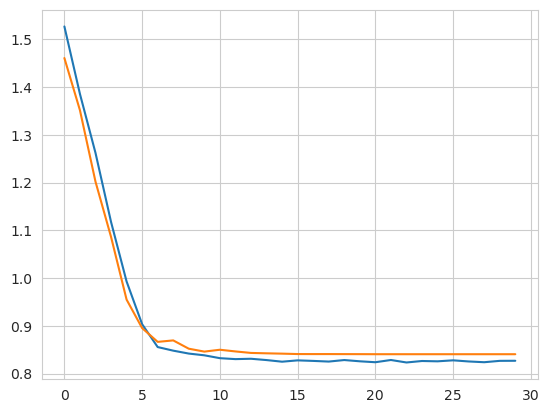

In [69]:
plt.plot(hist_19.history["loss"])
plt.plot(hist_19.history["val_loss"])

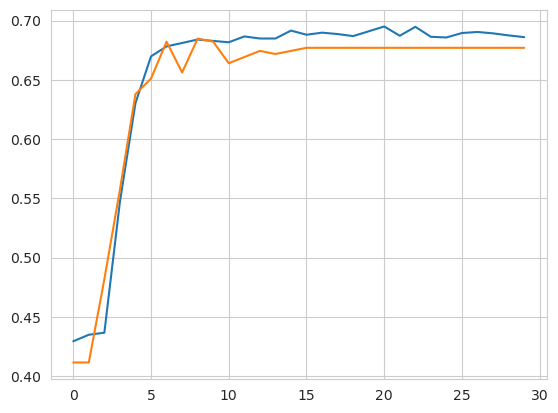

In [70]:
plt.plot(hist_19.history["acc"])
plt.plot(hist_19.history["val_acc"])

In [77]:
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    # XGBClassifier(),
    # AdaBoostClassifier(),
    # GaussianNB(),
    # LinearDiscriminantAnalysis(),
    # QuadraticDiscriminantAnalysis()
]

In [78]:
# logging for visual comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)
X_train_squeezed = np.squeeze(X_train)
X_test_squeezed = np.squeeze(X_test)
for clf in classifiers:
    clf.fit(X_train_squeezed, y_train)
    name = clf.__class__.__name__
    if VBS:
        print("-"*27)
        print(name)
        print('----------Results----------')
    train_predictions = clf.predict(X_test_squeezed)
    acc = accuracy_score(y_test, train_predictions)
    if VBS:
        print("Accuracy: {:.2%}".format(acc))
    train_predictions = clf.predict_proba(X_test_squeezed)
    ll = log_loss(y_test, train_predictions)
    if VBS:
        print("Log Loss: {:.2f}".format(ll))
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = pd.concat([log, log_entry], ignore_index=True)

---------------------------
KNeighborsClassifier
----------Results----------
Accuracy: 10.09%
Log Loss: 26.64
---------------------------
DecisionTreeClassifier
----------Results----------
Accuracy: 36.15%
Log Loss: 23.01
---------------------------
RandomForestClassifier
----------Results----------
Accuracy: 57.51%
Log Loss: 1.14


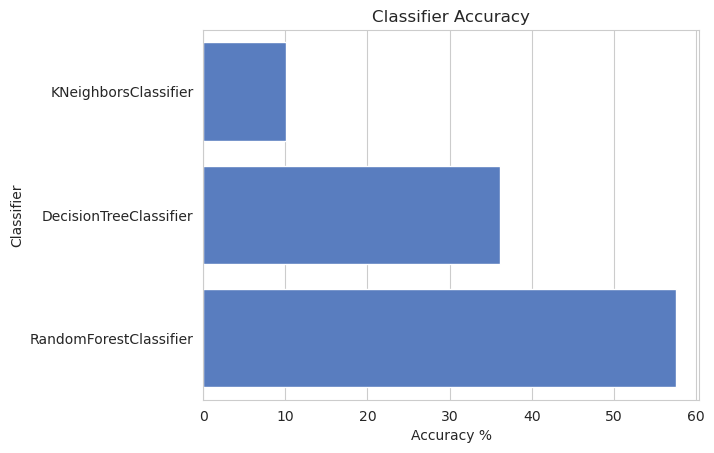

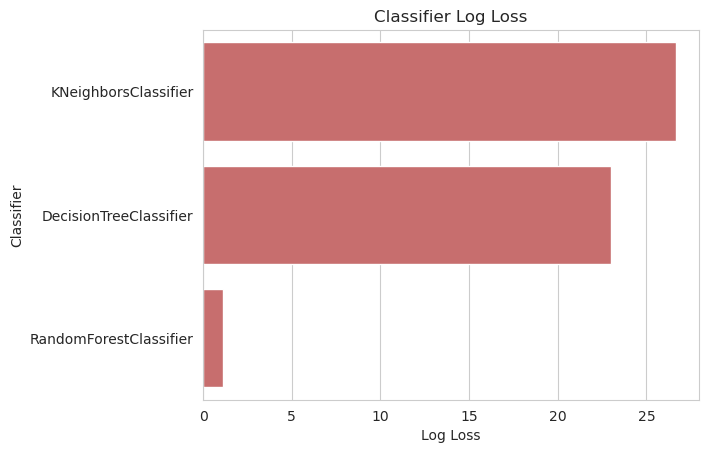

In [80]:
pdf_report2 = PdfPages('Classifiers_Results.pdf')
fig1 = plt.figure()
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
pdf_report2.savefig(fig1, bbox_inches='tight')
plt.show()

fig2 = plt.figure()
sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="r")
plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
pdf_report2.savefig(fig2, bbox_inches='tight')
plt.show()
pdf_report2.close()

In [82]:
svm_wo_pca = SVC(kernel='rbf')
svm_wo_pca.fit(X_train, y_train)

In [ ]:
e_pred_svm_wo_pca = svm_wo_pca.predict(X_test)
e_pred_prob_svm_wo_pca = svm_wo_pca.decision_function(X_test)